In [1]:
import sys
sys.path.append("../")

import torch
import numpy as np
import torch_geometric as pyg
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from models.GRDPG_GD_Unroll_unshared_normalized import GD_Unroll
from models.bigbird_attention import big_bird_attention
from models.early_stopper import EarlyStopper
from graspologic.embed import AdjacencySpectralEmbed 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pickle
from tqdm import tqdm

num_nodes = 150
d = 3
device = 'cuda'
epochs = 10000
lr=1e-3
gd_steps = 5
MODEL_FILE='../saved_models/glase_unshared_d3_normalized_fullATT.pt'
TRAIN_DATA_FILE='./data/sbm3_train.pkl'
VAL_DATA_FILE='./data/sbm3_val.pkl'

n = [int(num_nodes/3), int(num_nodes/3), int(num_nodes/3)]
p = [
     [0.8, 0.9, 0.1],
     [0.9, 0.6, 0.3], 
     [0.1, 0.3, 0.5]
]

print(torch.linalg.eig(torch.Tensor(p)))

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

x = torch.rand((num_nodes, d)).to(device)

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
Xhats = ase.fit_transform(adj_matrix)
best_error = np.linalg.norm(Xhats@Xhats.T-adj_matrix)
print("best error: ", best_error)


/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopyth

torch.return_types.linalg_eig(
eigenvalues=tensor([ 1.6707+0.j, -0.2407+0.j,  0.4700+0.j]),
eigenvectors=tensor([[ 0.7120+0.j,  0.6262+0.j, -0.3177+0.j],
        [ 0.6632+0.j, -0.7484+0.j,  0.0111+0.j],
        [ 0.2308+0.j,  0.2186+0.j,  0.9481+0.j]]))
best error:  65.891495


/home/sofia/lase/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [11]:
import torch.nn as nn
from torch_geometric.nn import TAGConv, Sequential
from models.Transformer_Block_v3 import Transformer_Block



class GD_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.gcn = TAGConv(in_channels, out_channels, K=1, normalize=False, bias=False)
        self.gat = Transformer_Block(in_channels, out_channels)

    def forward(self, input, edge_index, edge_index_2): 
        x_1 = self.gcn(input, edge_index) / input.shape[0] + ((input.shape[0]-1)/input.shape[0])*input
        x_2 = self.gat(input, edge_index_2, use_softmax=False, return_attn_matrix=False) / input.shape[0]
        return x_1 - x_2

class GD_Unroll(nn.Module):
    def __init__(self, in_channels, out_channels, gd_steps):
        super().__init__()

        self.gd_steps = gd_steps
        layers = []

        for _ in range(gd_steps):
            layers.append((GD_Block(in_channels, out_channels), 'x, edge_index, edge_index_2 -> x'))
        self.gd = Sequential('x, edge_index, edge_index_2', [layer for layer in layers])

    def forward(self, input, edge_index, edge_index_2): 
        x = input
        for step in range(self.gd_steps):
            self.gd[step].gat.W_3 = self.gd[0].gat.W_3
        x = self.gd(x, edge_index, edge_index_2)
                
        return x




In [12]:
model = GD_Unroll(d,d, gd_steps)
model.to(device)

for step in range(gd_steps):
    # TAGConv
    model.gd[step].gcn.lins[0].weight.data = torch.eye(d).to(device)
    model.gd[step].gcn.lins[0].weight.requires_grad = False
    model.gd[step].gcn.lins[1].weight.data = torch.nn.init.xavier_uniform_(model.gd[step].gcn.lins[1].weight)*lr

    # TransformerBlock
    model.gd[step].gat.lin2.weight.data = lr*torch.nn.init.xavier_uniform_(model.gd[step].gat.lin2.weight.data).to(device)
    # model.gd[step].gat.lin3.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].gat.lin2.weight.data).to(device)
    model.gd[step].gat.W_3.data = torch.ones([1,d]).to(device)

    model.gd[step].gat.lin4.weight.data = torch.eye(d).to(device)
    model.gd[step].gat.lin4.weight.requires_grad = False
    
out = model(x, edge_index, edge_index_2)

for step in range(gd_steps):
    print(model.gd[step].gat.W_3)

Parameter containing:
tensor([[1., 1., 1.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[1., 1., 1.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[1., 1., 1.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[1., 1., 1.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[1., 1., 1.]], device='cuda:0', requires_grad=True)


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.Tensor(gd_steps, d, d).to(device)
    for step in range(gd_steps):
        I_pq[step]=(torch.diag(model.gd[step].gat.W_3.data[0]).to('cpu'))
    loss = torch.norm((out@torch.sign(I_pq.mean(0))@out.T - to_dense_adj(edge_index).squeeze(0)))
    loss.backward() 
    optimizer.step() 

    if epoch % 500 == 0:
        print(f'Train Loss: {loss}')



Train Loss: 102.86705017089844


KeyboardInterrupt: 

<Axes: title={'center': 'G-LASE unshared weights (5 layers)'}>

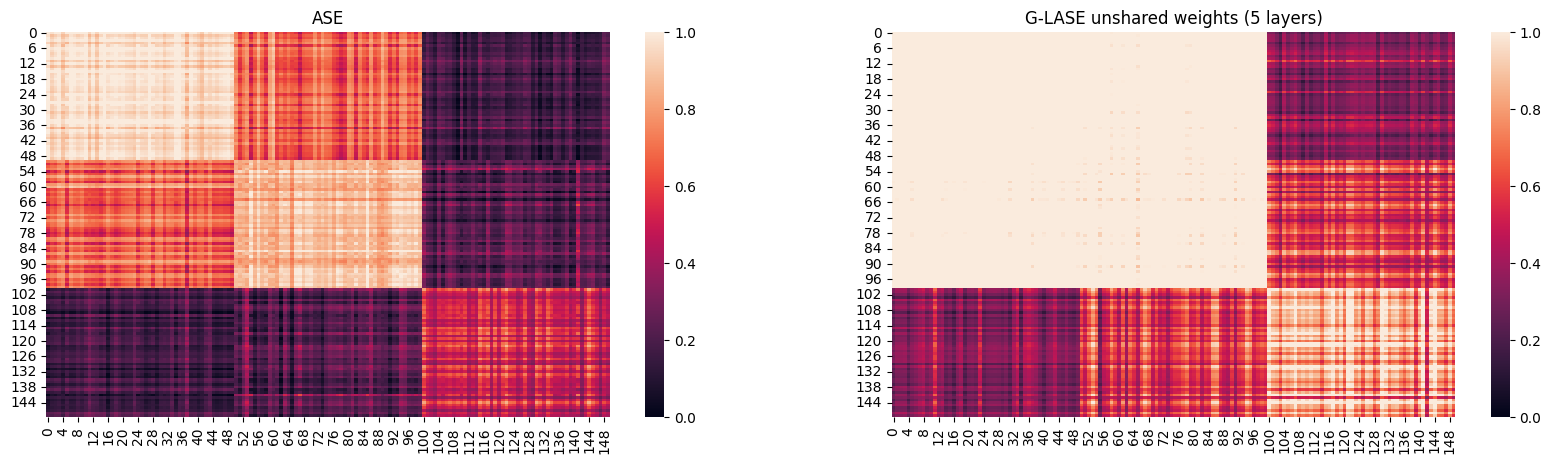

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

x_glase = out.detach()
x_glase = x_glase.to('cpu')
Q = I_pq.mean(0).to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(20,5))
axes[0].set_title('ASE')
sns.heatmap(Xhats@Xhats.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title(f'G-LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)